# DSC 475: Time Series Analysis and Forecasting Project-1
# Jingwen Zhong

#### Overview
This project is designed to provide you a hands-on experience working on an end-to-end time series analysis and forecasting solution using the well-established technique of ARIMA modeling. Starting with a real-world time series data set, you will have the opportunity to explore the data to determine if trend and seasonality is present. Then, by performing diagnostics, you will make a visual judgement on the best model hyperparameters to guide your solution. Finally, you will perform a grid search on the model  hyperparameters to determine the best model and evaluate its performance.

#### Problem Statement
The data for this project (Project1_DataSet.xlsx) represents 7 years of monthly data on airline miles flown in the United Kingdom. You are tasked with the goal of developing a forecasting model that can accurately predict the trend for future years. To achieve the final goal, answer each of the questions below.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib.pyplot'

In [3]:
data=pd.read_excel("Project1_DataSet.xlsx")
n=data.shape[0]
n

84

#### 1.	Create a time series of the plot of the data provided.	(5 pts)

        see below


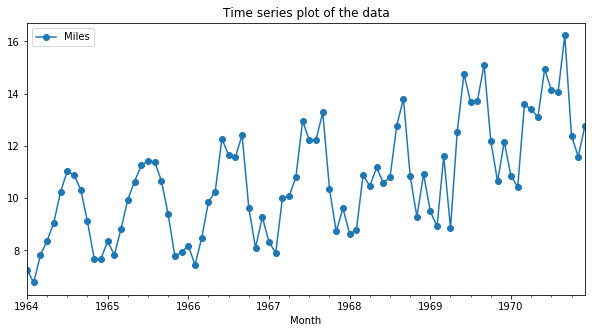

In [4]:
data.plot('Month', 'Miles',marker='o', linestyle='-',title='Time series plot of the data', figsize=(10,5))
plt.show()

#### 2.	Plot the autocorrelation function (ACF). From the ACF, what is the seasonal period? (5 pts)

        see below
        
        The seasonal period is 12
            

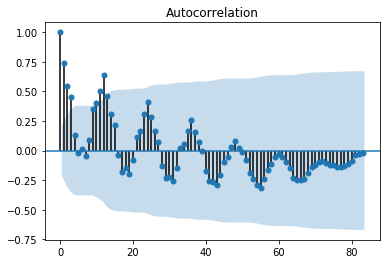

In [16]:
plot_acf(data['Miles'], lags=n-1)
plt.show()

#### 3.	Compute a moving average for the data to determine the trend in the data and overlay on the original time-series plot. What is a suitable choice for the moving average window length? (5 pts)

    a suitable choice for the moving average window length is 12


In [35]:
moving_average = []
month = []
data1 = data

for i in range(n):
    
    n1=data1.shape[0]
    
    new_data = data1[-12:]
  
    if n1 >= 12:
        a = new_data.Miles.mean()  
        moving_average.append(a)
        
        m = new_data.Month[n1-1]
        month.append(m)        
   

    data1 = data1.drop(n-1-i)

# rolling_mean = data.rolling(window=12).mean()
# plt.title("Moving average\n window size = {}".format(15))

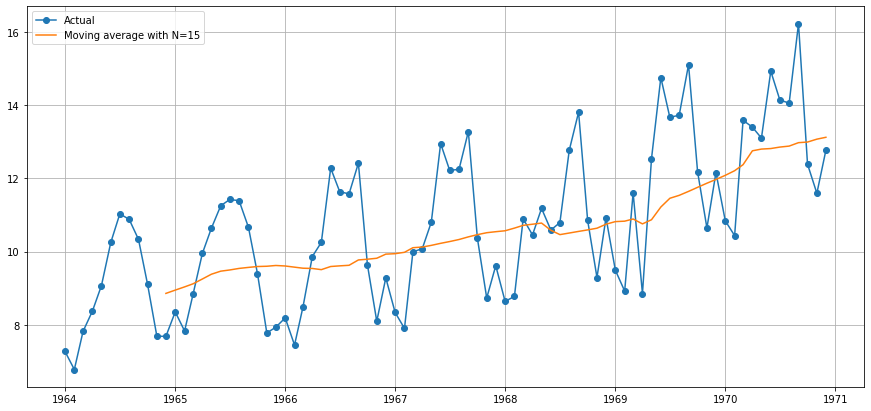

In [36]:
plt.figure(figsize=(15, 7))
plt.plot(data.Month, data.Miles, marker='o', linestyle='-',label = "Actual")
plt.plot(month, moving_average,label = 'Moving average with N=15' )
# plt.plot(data.Month,rolling_mean, label="Rolling mean trend")
plt.legend(loc="best")
plt.grid(True)
plt.show()

#### 4.	Observing the moving average plot in Q3, is the trend line increasing or decreasing? (5 pts)

    The trend is increasing

#### 5.	Compute the first difference of the data and plot the ACF and PACF for the differenced data. What are the significant lags based on the ACF and PACF? (5 pts)

    The significant lags based on the ACF are 3，4，5，7，9，12
    
    The significant lags based on th PACF are 2，3，4，5，7，8，11，20

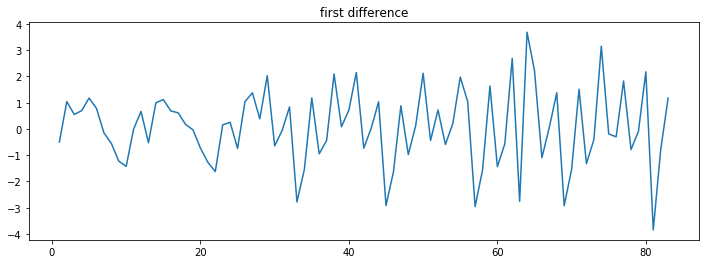

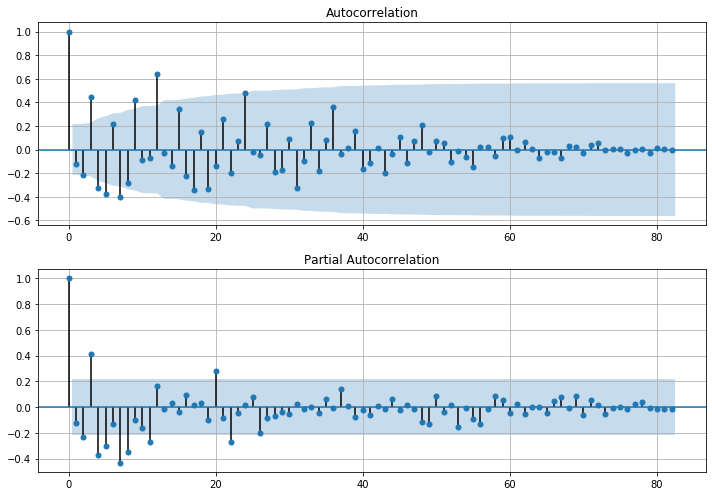

In [28]:
diffed = diff(data.iloc[:,1])
plt.figure(figsize=(12,4))
plt.title('first difference')
plt.plot(diffed)
plt.show()

fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(211)
fig=plot_acf(diffed,lags=n-2,ax=ax1)
plt.grid(True)
fig.tight_layout()


ax2=fig.add_subplot(212)
fig=plot_pacf(diffed,method='ywm',lags=n-2,ax=ax2)
plt.grid(True)
fig.tight_layout()

#### 6.	Using the output from Q5 above, perform a first seasonal difference with the seasonal period you identified in Q2, and plot the ACF and PACF again. What are the significant lags based on the ACF and PACF? (5 pts)


    The significant lags based on the ACF is 2, 10, 12
    
    The significant lags based on th PACF is 2, 4, 8, 10, 11

In [30]:
diffed2 = diffed- diffed.shift(12)

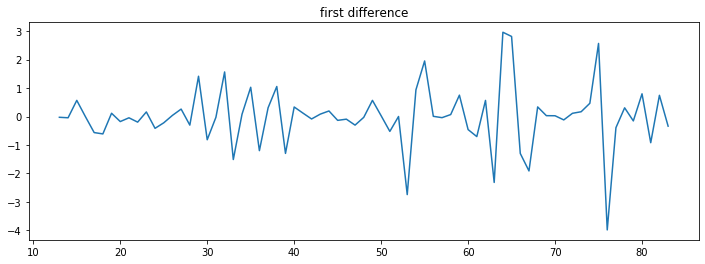

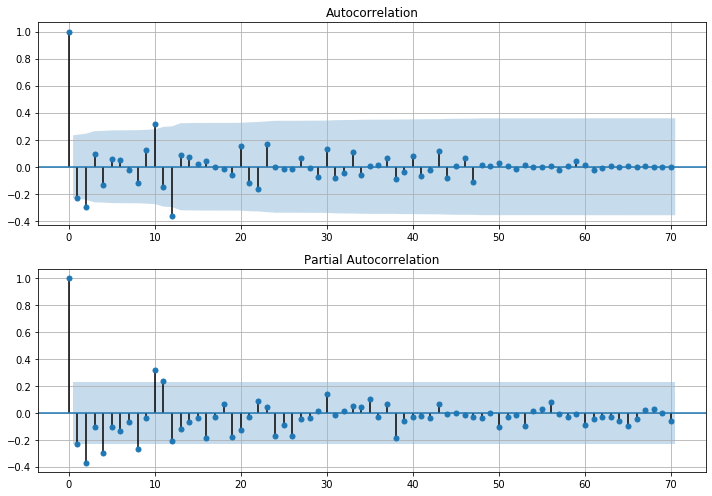

In [33]:
plt.figure(figsize=(12,4))
plt.title('first difference')
plt.plot(diffed2)
plt.show()

fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(211)
fig=plot_acf(diffed2[12:],lags=n-14,ax=ax1)
plt.grid(True)
fig.tight_layout()


ax2=fig.add_subplot(212)
fig=plot_pacf(diffed2[12:],method='ywm',lags=n-14,ax=ax2)
plt.grid(True)
fig.tight_layout()

#### 7.	Develop a suitable SARIMA model that can be applied on the time series. Use the first 6 years of data only to develop the model. (20 pts)

a.	To develop the model, vary the model parameters for the non-seasonal (p,d,q) and seasonal components (P,D,Q) and calculate the output for each combination of parameters.

b.	Use an evaluation criteria such as AIC, BIC or sum squared error or mean squared error to determine the best choice of parameters (p,d,q,P,D,Q). Note: AIC and BIC are metrics that is readily output by the ARIMA model.
    
    I used AIC to determine the best choice of parameters, which is
 $$SARIMAX(2,1,3)\times(1,1,0,12)$$

In [38]:
from datetime import date
new_data= data
a = date(1969,12,1)

for i in range(n):
    if new_data.Month[i]>a:
        new_data=new_data.drop(i)

In [62]:
from itertools import product
p = range(1, 3)
q = range(1, 4)

P = range(0, 3) 
Q = range(0, 2)

parameters = product(p, q, P, Q)

parameters_list = list(parameters)


In [66]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = UserWarning)
    results = []
    best_aic = float("inf")
    
    for parameter in parameters_list:
        try:
            SARIM_model = SARIMAX(new_data.Miles, order=(parameter[0], 1, parameter[1]), 
                                  seasonal_order=(parameter[2], 1, parameter[3], 12)).fit()
        except:
            continue   

        aic = SARIM_model.aic

        if aic < best_aic:
            best_model = SARIM_model
            best_aic = aic
            best_parameters = parameters

        results.append([parameter, SARIM_model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    print(result_table.sort_values(by='aic', ascending=True).head())
    print(best_model.summary())


      parameters         aic
32  (2, 3, 1, 0)  147.283322
31  (2, 3, 0, 1)  147.796081
34  (2, 3, 2, 0)  149.236374
33  (2, 3, 1, 1)  149.589238
8   (1, 2, 1, 0)  149.858222
                                      SARIMAX Results                                      
Dep. Variable:                               Miles   No. Observations:                   72
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 12)   Log Likelihood                 -66.642
Date:                             Sun, 31 Jan 2021   AIC                            147.283
Time:                                     23:13:51   BIC                            161.826
Sample:                                          0   HQIC                           152.960
                                              - 72                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

In [67]:
n2= len(best_model.resid)

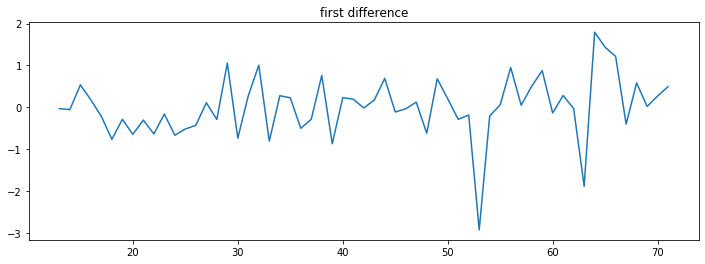

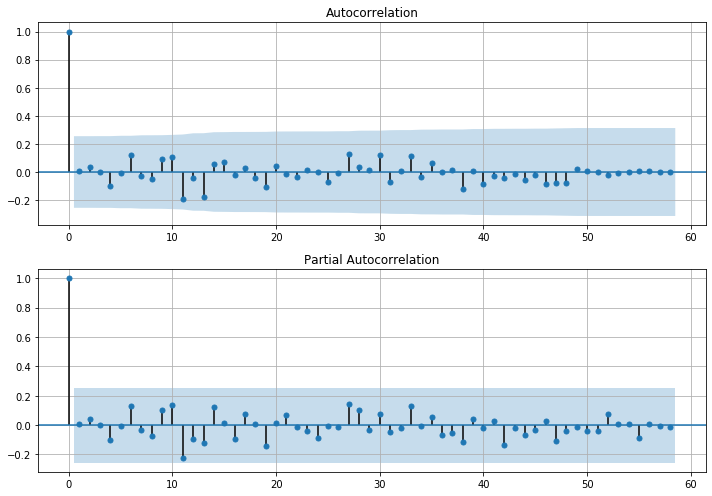

In [68]:
plt.figure(figsize=(12,4))
plt.title('first difference')
plt.plot(best_model.resid[13:])
plt.show()

fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(211)
fig=plot_acf(best_model.resid[13:], lags=n2-14,ax=ax1)
plt.grid(True)
fig.tight_layout()


ax2=fig.add_subplot(212)
fig=plot_pacf(best_model.resid[13:], method='ywm',lags=n2-14,ax=ax2)
plt.grid(True)
fig.tight_layout()

#### 8.	Use the model parameters determined in Q7 above to forecast for the 7th year. Compare the forecast with actual values. Comment on your observations. (10 pts)

     The MSE of my model is 0.738411022687372, which is relatively small, and all points are in between the confidence interval. We can conclude that the model can be used.

In [74]:
forecast = best_model.predict(start =n2, end = n2+11)

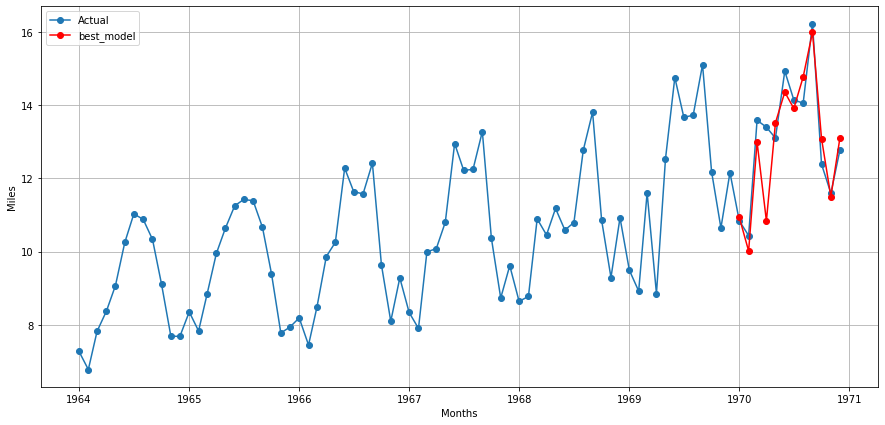

In [75]:
plt.figure(figsize=(15, 7))
plt.plot(data.Month, data.Miles, marker='o', linestyle='-',label = "Actual")

plt.plot(data.Month[n2:], forecast, color='r',marker='o', linestyle='-', label="best_model")

plt.xlabel('Months')
plt.ylabel('Miles')

plt.legend(loc="best")
plt.grid(True)
plt.show()

In [84]:
forecast2 = best_model.get_prediction(start = n2, end = n2+11)
pred_ci = forecast2.conf_int()

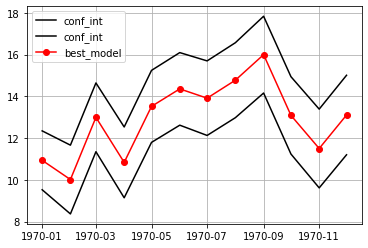

In [85]:
plt.plot(data.Month[n2:], pred_ci, label ="conf_int", color='k')

plt.plot(data.Month[n2:], forecast, color='r',marker='o', linestyle='-', label="best_model")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [86]:
mse = ((data.Miles[n2:]-forecast)**2).mean()
mse

0.738411022687372